In [20]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [4]:
import numpy as np
import itertools

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt

import pybinding as pb

import numpy as np
from matplotlib.patches import Polygon

In [17]:
def compute_reciprocal_basis(real_basis, volume):
    cv1, cv2, cv3 = np.split(real_basis, 3, axis=0)
    rv1 = 2 * np.pi * np.cross(cv2.squeeze(), cv3.squeeze()) / volume
    rv2 = 2 * np.pi * np.cross(cv3.squeeze(), cv1.squeeze()) / volume
    rv3 = 2 * np.pi * np.cross(cv1.squeeze(), cv2.squeeze()) / volume
    reciprocal_basis = np.concatenate([x[None, :] for x in (rv1, rv2, rv3)], axis=0)
    return reciprocal_basis

def compute_volume(basis):
    v1, v2, v3 = np.split(basis, 3, axis=0)
    cross = np.cross(v2, v3, axisa=1, axisb=1)
    box = np.sum(v1 * cross)
    return np.abs(np.squeeze(box))

def check_inside(points, plane_equations):
    masks = np.array([pe(points) > 0. for pe in plane_equations])
    print(masks)
    mask = np.sum(masks, axis=0)
    return mask == 0

def compute_points(primitives):
    p = [origin]
    [p.append(p0) for p0 in primitives]
    p.append(np.sum(primitives, axis=0))
    pairs = np.sum(np.array(list(itertools.combinations(primitives, 2))), axis=1)
    [p.append(p0) for p0 in pairs]
    return p

def generate_plane_vectors(primitives):
    origin_pairs = list(itertools.combinations(primitives, 2))
    origin_pairs = [np.squeeze(x) for x in np.split(np.array(origin_pairs), 2, axis=1)]
    origin_plane_vectors = np.cross(origin_pairs[0], origin_pairs[1])
    
    tmp = np.stack([origin_plane_vectors, -origin_plane_vectors], axis=1)  # put the cross product in either direction
    origin_plane_vectors = use_vector_facing_away(origin, center, tmp)  # select the direction that points away from the center

    contra_pairs = list(itertools.combinations(-primitives, 2))
    contra_pairs = [np.squeeze(x) for x in np.split(np.array(contra_pairs), 2, axis=1)]
    contra_plane_vectors = np.cross(contra_pairs[0], contra_pairs[1])
    
    tmp = np.stack([contra_plane_vectors, -contra_plane_vectors], axis=1)
    contra_plane_vectors = use_vector_facing_away(contra, center, tmp)
    
    points = [origin for i in range(3)]
    [points.append(contra)  for i in range(3)]
    
    vectors = np.concatenate([origin_plane_vectors, contra_plane_vectors], axis=0)
    
    return points, vectors

def use_vector_facing_away(point0, center, vectors):
    # checks if the vector is closer or further from the center
    # this method assumes that given the origin or contra, moving along one of the 3 related plane vectors 
    new_point = point0 + vectors
    dists = np.sqrt(np.sum((new_point - center)**2, axis=-1))
    idxs = np.argmax(dists, axis=1)
    return np.stack([v[pair_idx, :] for (pair_idx, v) in zip(idxs, vectors)], axis=0)


def make_plane_equation(p0, pv):
    def _plane_equation(vector):
        return np.sum(pv * (vector - p0), axis=-1)
    return _plane_equation


def get_ds(points, vectors):
    x = [np.sum(- pv * p0) for p0, pv in zip(points[:3], vectors[:3])]
    [x.append(np.sum(pv * p0)) for p0, pv in zip(points[3:], vectors[3:])] # change the sign because the normal is pointing in the wrong direction
    return x
        
def compute_distance(d0, d1, v):
    return np.abs(d0 - d1) / np.sqrt(np.sum(v**2))

def get_distances(ds, vectors):
    ds = np.split(np.array(ds), 2)
    vectors = np.split(np.array(vectors), 2, axis=0)
    return np.array([compute_distance(d0, d1, v) for d0, d1, v in zip(ds[0], ds[1], vectors[0])])

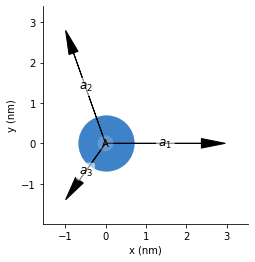

20.12070088249584
26.137558407358714
[[ 0.33695998  0.11913335  0.20634503]
 [-0.          0.35740004  0.20634503]
 [ 0.         -0.          0.41269003]]
[[0.33695998 0.11913335 0.20634502]
 [0.         0.35740008 0.20634502]
 [0.         0.         0.41269001]]
[[0.33695998 0.         0.        ]
 [0.11913335 0.35740004 0.        ]
 [0.20634503 0.20634503 0.41269003]]


In [83]:
real_basis = np.array([[2.9677114487,   0.0000000000,   0.0000000000], [ -0.9892372125,   2.7979851644,   0.0000000000], [-0.9892372125,  -1.3989927157,   2.4231261546]])
inv_real_basis = np.linalg.inv(real_basis)

lattice = pb.Lattice(a1=[2.9677114487,   0.0000000000,   0.0000000000], a2=[ -0.9892372125,   2.7979851644,   0.0000000000], a3=[-0.9892372125,  -1.3989927157,   2.4231261546])
lattice.add_sublattices(
    ('A', [0, 0, 0])  # add an atom called 'A' at position [0, 0]
)
lattice.plot()
plt.show()

x = np.array(lattice.reciprocal_vectors()) / (2*np.pi)
volume = compute_volume(real_basis)
print(volume)
print(2.9677114487**3)

y = compute_reciprocal_basis(real_basis, volume)
print(y / (2*np.pi))
print(x)
print(np.linalg.inv(real_basis))



In [35]:
np.linalg.inv(np.array([[0.5, -1], [0., 2.]]))

array([[2. , 1. ],
       [0. , 0.5]])

[[0.9 0.5]]
[[1.1  1.25]]
[[1.1 1. ]]
[[1.1  1.75]]
[[0.9  1.75]]


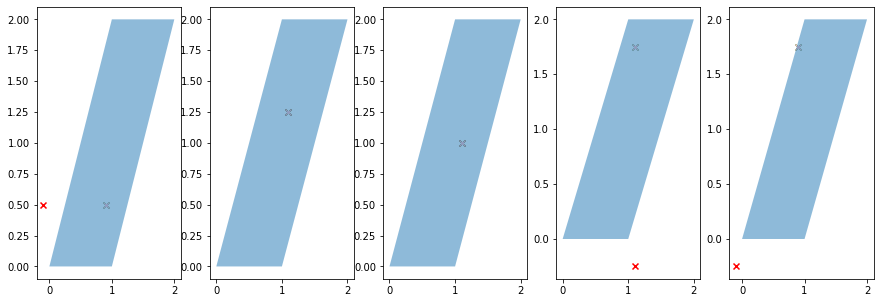

In [49]:


points = [np.array([[-0.1, 0.5]]), 
np.array([[1.1, 1.25]]),
np.array([[1.1, 1.]]),
np.array([[1.1, -0.25]]),
np.array([[-0.1, -0.25]])]

n_points = len(points)

polygon = np.array([[0.0, 0.0], 
                    [1., 0.],
                    [2., 2.],
                    [1., 2.]])

basis = np.array([[1.0, 0.0],
                  [1.,  2.]]).T

spanning_vector = np.sum(basis, axis=0, keepdims=True)

inv_basis = np.linalg.inv(basis)

poly = Polygon(polygon, alpha=0.5)
fig, axs = plt.subplots(1, n_points, figsize=(15, 5))

ax.set_xlim(-0.5, 2.5)
ax.set_ylim(-0.5, 1.5)

def pbc(point):
    y = point.dot(inv_basis)
    y = inv_basis.dot(point.T)
    y = np.fmod(y, 1.) 
    y[y < 0] += 1.
    y = basis.dot(y)
    return y.T

def pbcb(point):
    b = basis.T   # basis along the row vectors
    inv_basis = np.linalg.inv(b)
    y = point.dot(inv_basis)
    y = np.fmod(y, 1.) 
    y[y < 0] += 1.
    y = y.dot(b)
    return y

for p, ax in zip(points, axs):
    ax.scatter(p[0, 0], p[0, 1], marker='x', color='red')
    y = pbc(p)
    ax.scatter(y[0, 0], y[0, 1], marker='x', color='green')
    y = pbcb(p)
    print(y)
    ax.scatter(y[0, 0], y[0, 1], marker='x', color='pink')
    poly = Polygon(polygon, alpha=0.5)
    ax.add_patch(poly)

plt.show()

In [82]:
def _periodic_boundaries_step(walkers):
    talkers = walkers.dot(inv_real_basis)
    talkers = np.fmod(talkers, 1.)
    talkers = np.where(talkers < 0, talkers + 1., talkers)
    talkers = talkers.dot(real_basis)
    return talkers
    
def _compute_ee_vectors(walkers):
    re1 = np.expand_dims(walkers, axis=1)
    re2 = np.transpose(re1, [0, 2, 1, 3])
    ee_vectors = re1 - re2
    return ee_vectors

def _compute_ee_vectors_periodic(walkers):
    unit_cell_walkers = walkers.dot(inv_real_basis)  # translate to the unit cell
    # print(unit_cell_walkers)
    assert (np.abs(unit_cell_walkers) < 1.).all()
    # tmp = jnp.bitwise_and(unit_cell_walkers > 1., unit_cell_walkers < 0.)
    # assert not jnp.any(tmp)  # does not work with tracing because it is input dependent
    unit_cell_ee_vectors = _compute_ee_vectors(unit_cell_walkers)
    assert (np.abs(unit_cell_ee_vectors) < 1.).all()
    print(unit_cell_ee_vectors[0, 0])
    print((np.floor_divide(2 * unit_cell_ee_vectors, np.ones_like(unit_cell_ee_vectors)) * 1.)[0, 0])
    min_image_unit_cell_ee_vectors = unit_cell_ee_vectors - (2 * unit_cell_ee_vectors / np.ones_like(unit_cell_ee_vectors)).astype(int) * 1.  
    assert (np.abs(min_image_unit_cell_ee_vectors) < 1.).all()
    # 1 is length of unit cell put it here for clarity
    min_image_ee_vectors = min_image_unit_cell_ee_vectors.dot(real_basis)
    return min_image_ee_vectors

n_walkers = 1000
np.random.seed(1)
x = _periodic_boundaries_step(np.random.normal(0, 2, (n_walkers, 4, 3)))

# import jax.numpy as jnp
np.floor_divide(-1.2, 1)

(np.array([-1.2]) / np.array([1.])).astype(int).astype(np.float32)

# _compute_ee_vectors_periodic(x).dot(inv_real_basis)

array([-1.], dtype=float32)

In [43]:
# Notes
# plane vector is perpendicular to the plane
# equation of a plane is given by P . n = 0 where P is any vector in the plane (parameterised by x y and z) 
# and n is the plane vector (the vector perpendicular to the plane)
# plan is to get all the equations of the planes then if the output is
# 0 it is on the plane
# positive it is outside the cell
# negative it is inside the cell
# need to make sure the plane vectors are pointing outside the cell for this to work

primitive_vectors = np.array([[-1/2., 1/2., 1/2.],
                              [1/2., -1/2., 1/2.],
                              [1/2., 1/2., -1/2.]])  # clockwise primitive vectors, taking the negative keeps clockwise

inv_primitive_vectors = np.linalg.inv(primitive_vectors)



(eigs, eigv) = np.linalg.eig(primitive_vectors)
print(eigs) # none of the eigenvalues are zero, they are linearly independent

origin = np.array([0.0, 0.0, 0.0])  # start with one nucleus in the corner at the origin and all primitive vectors starting here

contra = np.sum(primitive_vectors, axis=0)  # contra is not a technical name I am using it to mean 'the point opposite (the origin)'

center = np.sum(primitive_vectors, axis=0) / 2.  # the center is defined as halfway between the contra and the origin (this doens't hold for weird shapes??)

 # explicitly figuring out the points to confirm with the points function
verts = [[0.0, 0.0, 0.0], # origin corner 1
          [-1/2., 1/2., 1/2.], # center 1 primitive 1
          [0., 1., 0.],  # corner 2 p1 + p2
          [1/2., 1/2., -1/2.],  # center 2 primitive 2
          [0., 0., 1.],  # corner 3 p1 + p3
          [1/2., -1/2., 1/2.],  # center 3 primitive 3
          [1., 0., 0.],  # corner 4 p3 + p2
          [1/2., 1/2., 1/2.]]  # center 4 p1 + p2 + p3  
        

[ 0.5 -1.  -1. ]


In [123]:
# This confirms that the sampler is good 

import numpy as np
from matplotlib.patches import Polygon

pvs = primitive_vectors
points, vectors = generate_plane_vectors(primitive_vectors)
basis = primitive_vectors
inv_basis = np.linalg.inv(basis)

plane_equations = [make_plane_equation(p0, pv) for p0, pv in zip(points, vectors)]

tmp_start_og = np.random.normal((0.25, 0.25, 0.25), (0.1, 0.1, 0.1), (5, 3))


print(int(False))


# tmp += pvs[0] + pvs[1]
tmp_start = tmp_start_og + pvs[0] - pvs[1] + pvs[2] * 4.
print(tmp_start)
mask = check_inside(tmp_start, plane_equations)
print(mask)

y = tmp_start.dot(inv_basis)
y = np.fmod(y, 1.)
y[y < 0.] += 1.


# y[y < 0.] *= -1.
y = y.dot(basis)

mask2 = np.isclose(y, tmp_start_og)

print(y)

print(tmp_start)

print(mask2)

0
[[ 1.24968635  3.2598758  -1.91774269]
 [ 1.31478902  3.13391298 -1.58179106]
 [ 1.21209361  3.28662389 -1.75035585]
 [ 1.38348334  3.14248596 -1.75959839]
 [ 1.09509829  3.26780334 -1.87730222]]
[[False False False False False]
 [ True  True  True  True  True]
 [False False False False False]
 [ True  True  True  True  True]
 [False False False False False]
 [ True  True  True  True  True]]
[False False False False False]
[[0.24968635 0.2598758  0.08225731]
 [0.31478902 0.13391298 0.41820894]
 [0.21209361 0.28662389 0.24964415]
 [0.38348334 0.14248596 0.24040161]
 [0.09509829 0.26780334 0.12269778]]
[[ 1.24968635  3.2598758  -1.91774269]
 [ 1.31478902  3.13391298 -1.58179106]
 [ 1.21209361  3.28662389 -1.75035585]
 [ 1.38348334  3.14248596 -1.75959839]
 [ 1.09509829  3.26780334 -1.87730222]]
[[ True  True  True]
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]]


In [46]:
points, vectors = generate_plane_vectors(primitive_vectors)

plane_equations = [make_plane_equation(p0, pv) for p0, pv in zip(points, vectors)]



def vector_normalisation(vectors):
    return np.sqrt(np.sum(vectors**2, axis=-1, keepdims=True))

ds = get_ds(points, vectors)  # vector is a point in the plane

distances = get_distances(ds, vectors)

p0 = points[0] + distances[0] * vectors[3]

print(distances)
print(vector_normalisation(vectors))
print(plane_equations[3](p0))
print(np.sqrt(np.sum(vectors[0]**2)))

# assert plane_equations[3](p0) == 0.0
print(np.split(np.array(ds), 2))
vectors = np.split(np.array(vectors), 2, axis=0)
print(vectors)

[0.70710678 0.70710678 0.70710678]
[[0.70710678]
 [0.70710678]
 [0.70710678]
 [0.70710678]
 [0.70710678]
 [0.70710678]]
-0.14644660940672627
0.7071067811865476
[array([0., 0., 0.]), array([0.5, 0.5, 0.5])]
[array([[-0.5, -0.5, -0. ],
       [-0.5,  0. , -0.5],
       [-0. , -0.5, -0.5]]), array([[ 0.5,  0.5,  0. ],
       [ 0.5, -0. ,  0.5],
       [ 0. ,  0.5,  0.5]])]


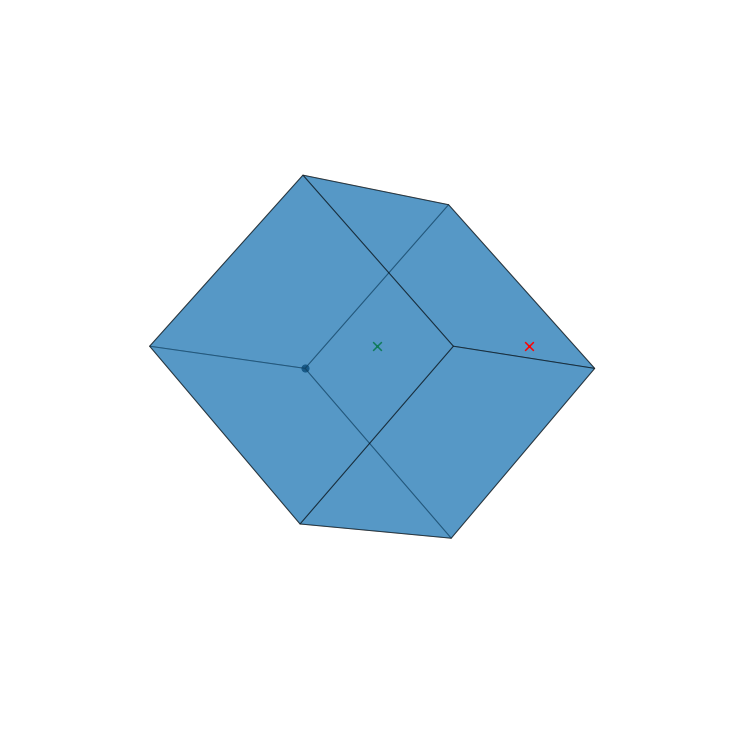

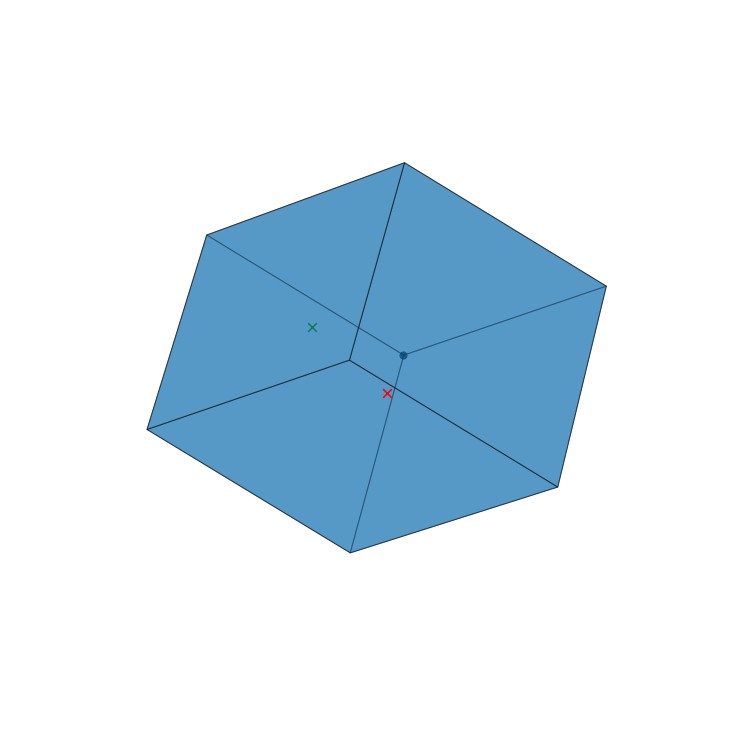

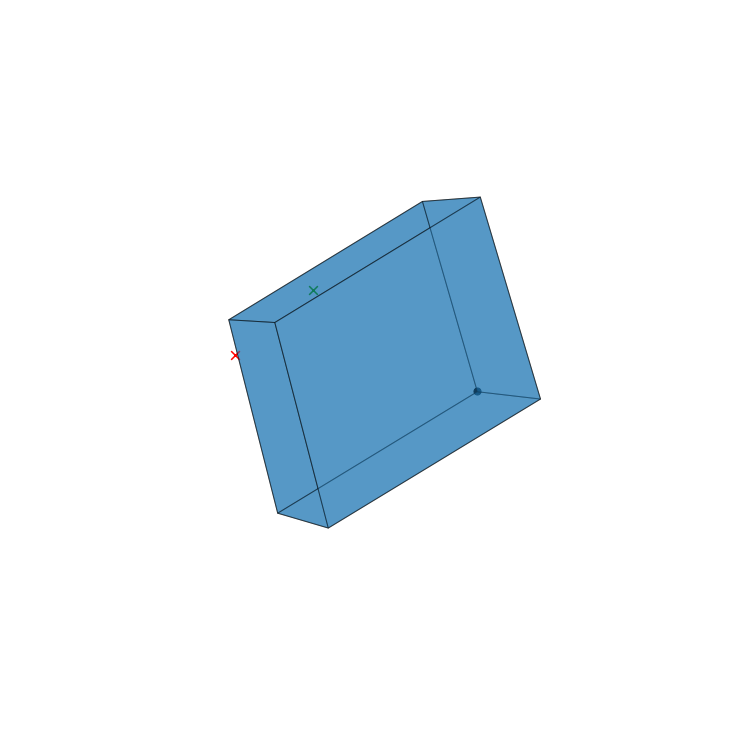

In [47]:

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt

def get_min_max(x):
    return np.min(x), np.max(x)

def plot_rotations(verts, test_point):
    for theta in [0, 60, 120]:
        fig = plt.figure(figsize=(10, 10))
        ax = Axes3D(fig)
        ax.view_init(30, theta)
        for i, v in enumerate(verts):
            z = Poly3DCollection([v])
            z.set_alpha(0.5)
            z.set_edgecolor('black')
            ax.add_collection3d(z)
        ax.scatter(0.0, 0.0, 0.0, color='black', s=50)
        ax.set_axis_off()
        ax.scatter(*test_point, color='red', s=75, marker='x')
        ax.scatter(*periodic(test_point), color='green', s=75, marker='x')
        ax.autoscale(enable=True,axis='both')
        ax.set_xlim(get_min_max(verts[..., 0]))
        ax.set_ylim(get_min_max(verts[..., 1]))
        ax.set_zlim(get_min_max(verts[..., 2]))
        plt.show()
    
def periodic(x):
    polygon_vector = np.sum(primitive_vectors, axis=0)
    y = np.fmod(test_point + polygon_vector/2., polygon_vector)
    y = np.where(y < 0., y, y + polygon_vector)
    y -= polygon_vector/2.
    return y

verts = np.array([[[0.0, 0.0, 0.0], [-1/2., 1/2., 1/2.], [0., 1., 0.], [1/2., 1/2., -1/2.]],
         [[0.0, 0.0, 0.0], [-1/2., 1/2., 1/2.], [0., 0., 1.], [1/2., -1/2., 1/2.]],
         [[0.0, 0.0, 0.0], [1/2., 1/2., -1/2.], [1., 0., 0.], [1/2., -1/2., 1/2.]],
         [[1/2., 1/2., 1/2.], [0., 1., 0.], [1/2., 1/2., -1/2.], [1., 0., 0.]],
         [[1/2., 1/2., 1/2.], [0., 1., 0.], [-1/2., 1/2., 1/2.], [0., 0., 1.]],
         [[1/2., 1/2., 1/2.], [0., 0., 1.], [1/2., -1/2., 1/2.], [1., 0., 0.]]])

test_point = (0.25, 0.25, 0.25)
test_point = (-0.4, 0., 0.)
test_point = (0.5, 0.75, 0.5)
plot_rotations(verts, test_point)

In [48]:
y = np.split(np.array(list(itertools.combinations(primitive_vectors, 2))), 2, axis=1)
print(y[0].shape, y[1].shape)

(3, 1, 3) (3, 1, 3)


In [49]:
np.cross(y[0], y[1])
# np.cross(primitive_vectors[0], primitive_vectors[1])

array([[[ 0.5,  0.5,  0. ]],

       [[-0.5,  0. , -0.5]],

       [[ 0. ,  0.5,  0.5]]])

In [50]:
print(primitive_vectors[0])
print(primitive_vectors[1])

[-0.5  0.5  0.5]
[ 0.5 -0.5  0.5]


In [51]:
import numpy as np
np.fmod(0.25, 1.)

0.25

In [52]:
# # vector change of basis tests
# tmp = np.array([[1., 0., 0.],
#                 [0.5, 0.5, 0.1],
#                 [2., 3., 4.],
#                 [-1., 2., -3.]])

# new_vectors = [inv_primitive_vectors.dot(t) for t in tmp]

# print(new_vectors)

# Transpose because they are row vectors 
basis = np.array([[1., 0.],
                  [1., 1.]])

inv_basis = np.linalg.inv(basis.T)

tmp = np.array([[1., 0.],
                [0., 1.],
                [2., 1.]])

new_vectors = [inv_basis.dot(t) for t in tmp]

print(new_vectors)

old_vectors = [basis.T.dot(t) for t in new_vectors]
    
print(old_vectors)


[array([1., 0.]), array([-1.,  1.]), array([1., 1.])]
[array([1., 0.]), array([0., 1.]), array([2., 1.])]


sv [[2. 1.]]
[[-0.1  1.1]]
y [[-0.1  0.1]]
[[-0.1  0.2]]
(1, 2)
[[ True False]]
[[-0.1  0.2]]
[[0.9 0.2]]
[[0.9 1.1]]
(1, 2)


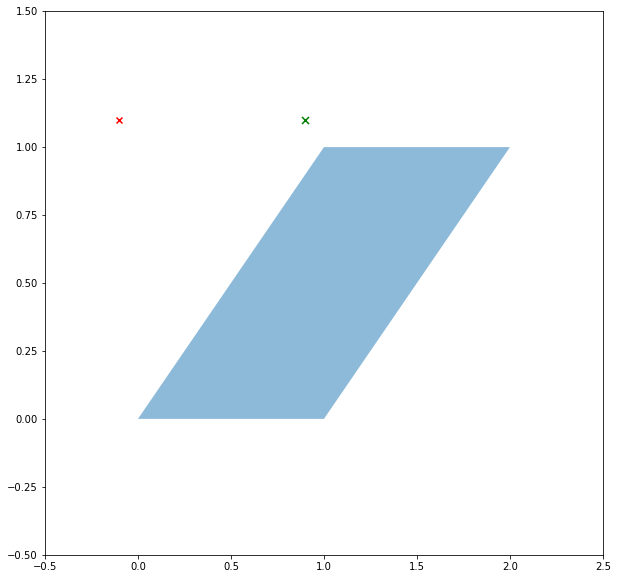

In [53]:
points = np.array([[0.0, 0.0], 
                  [1., 0.],
                   [2., 1.],
                  [1., 1.]
                   ])

basis = np.array([[1.0, 0.0],
                  [1.,  1.]])

spanning_vector = np.sum(basis, axis=0, keepdims=True)

inv_basis = np.linalg.inv(basis)

tmp = np.array([[1., 0.],
                [0., 1.],
                [2., 1.]])

tmp = np.array([[-0.1, 1.1]])


from matplotlib.patches import Polygon

p = Polygon(points, alpha=0.5)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.add_patch(p)
ax.set_xlim(-0.5, 2.5)
ax.set_ylim(-0.5, 1.5)
ax.scatter(tmp[:, 0], tmp[:, 1], marker='x', color='red', )


print('sv', spanning_vector)

y = tmp
print(tmp)
y = np.fmod(y, spanning_vector)
print('y', y)
# change basis 
y = inv_basis.dot(y.T).T

# fmod that mf
print(y)
print(y.shape)
# if negative (in the new basis! add on ONE)
print(y < 0)
print(y)
y[y < 0] += 1.
print(y)
# convert back
y = basis.dot(y.T).T
print(y)
print(y.shape)
ax.scatter(y[:, 0], y[:, 1], marker='x', color='green', s=50)



def plot_rotations(verts, test_point):

        ax.scatter(0.0, 0.0, 0.0, color='black', s=50)
        ax.set_axis_off()
        ax.scatter(*test_point, color='red', s=75, marker='x')
        ax.scatter(*periodic(test_point), color='green', s=75, marker='x')
        ax.autoscale(enable=True,axis='both')
        ax.set_xlim(get_min_max(verts[..., 0]))
        ax.set_ylim(get_min_max(verts[..., 1]))
        ax.set_zlim(get_min_max(verts[..., 2]))
        plt.show()
    
def periodic(x):
    polygon_vector = np.sum(primitive_vectors, axis=0)
    y = np.fmod(test_point + polygon_vector/2., polygon_vector)
    y = np.where(y < 0., y, y + polygon_vector)
    y -= polygon_vector/2.
    return y


plt.show()

sv [[2. 1.]]
[[1.1  1.25]]
basis change [[-0.15  1.25]]
new_sv [[1. 1.]]
fmod [[-0.15  0.25]]
negative [[ True False]]
shifted y [[0.15 0.25]]
basis back [[0.4  0.25]]


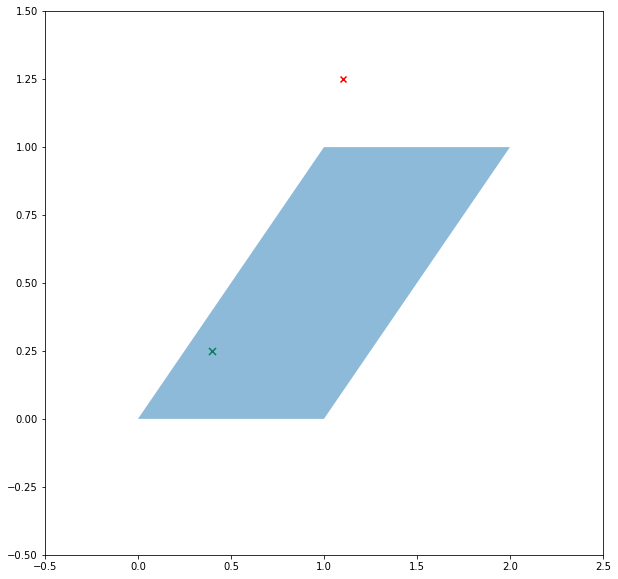

In [69]:

from matplotlib.patches import Polygon

points = np.array([[0.0, 0.0], 
                  [1., 0.],
                   [2., 1.],
                  [1., 1.]
                   ])

basis = np.array([[1.0, 0.0],
                  [1.,  1.]])

spanning_vector = np.sum(basis, axis=0, keepdims=True)
print('sv', spanning_vector)

inv_basis = np.linalg.inv(basis)

tmp = np.array([[1.5, 1.25]])
tmp = np.array([[1.1, 1.25]])


p = Polygon(points, alpha=0.5)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.add_patch(p)
ax.set_xlim(-0.5, 2.5)
ax.set_ylim(-0.5, 1.5)
ax.scatter(tmp[:, 0], tmp[:, 1], marker='x', color='red')


y = tmp
print(y)

y = inv_basis.T.dot(y.T).T
print('basis change', y)
sv = inv_basis.T.dot(spanning_vector.T).T
print('new_sv', sv)

y = np.fmod(y, sv)
print('fmod', y)




# fmod
# if negative (in the new basis! add on ONE)
print('negative', y < 0)
y[y < 0] *= -1.
print('shifted y', y)

# convert back
y = basis.T.dot(y.T).T
print('basis back', y)

ax.scatter(y[:, 0], y[:, 1], marker='x', color='green', s=50)

plt.show()

[[0.15 0.75]]
(1, 2) (1, 2)
[[0. 1.]]
[[0.15 0.75]]
[[0.9  0.75]]
[[0.9  0.75]] [[-0.1  -0.25]]


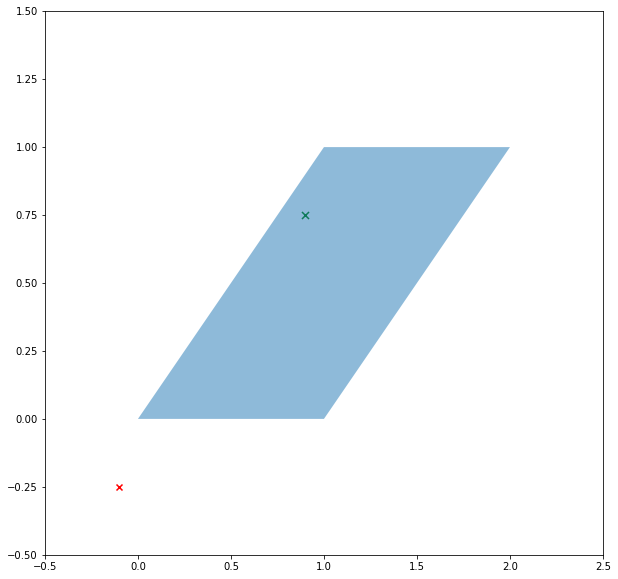

np.cross(y[0], y[1])